<a href="https://colab.research.google.com/github/cric96/DL-exercise/blob/main/test_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks applied in Aggregate Computing
In this notebook, I tried to apply Neural Network and Recurrent Neural Networks (RNN) in the context of Aggregate Computing (AC).

## Model

Usually, RNN are trained in indipendent sequences. In case of Aggregate Computing, the temporal sequence are correlated with each other following a neighbourhood policy. 

The key idea here is:
- express the system as a graph. Offline we can imagine to access to the entire system
- in each time step, we aggregate data from the neighbours and then we use RNN to compute the right output

# Imports

In [1]:
import tensorflow as tf
from datetime import datetime
from numpy.random import seed
import datetime
%load_ext tensorboard

# Simple Graph

In this model, I model graph as:
$G = (N, E)$

Where, $N$ contains a feature vector and an output vector.

$E$ is expressed as adjacency matrix, so: $E_{i,j} = 1$ iff $i$ is neighbour of $j$.

Input is a matrix contains the concatenation of feature vector and output vector, something like: $ I(n) = <f(n), o(n)>$.
Where $<a, b, c>$ means the column-wise fector concatenation. 
For instance, giving a vector $a = [1, 2]$ and $b = [2, 3]$, $<a,b> = [1, 2, 2, 3]$.

The neighbour aggregation data can be computed leveraging matrix multiplication --- so increasing traning performance.
$$ reduction(E * F) $$
Where F contains all node features.
$reduction$ is a multiset function (e.g. summation, mean,...).

Pay attention, this model can be easly used in a decentralized situation.
Indeed, the data aggregation will be done without global adjency matrix but only retrieving neighbour data. The dense layer already works locally.

In [2]:
n = 50000
feature = tf.constant([
                     [1], 
                     [0],
                     [0],
                     [0],
                    ], dtype=tf.float32)
output = tf.constant([
                     [0], 
                     [n],
                     [n],
                     [n],
                    ], dtype=tf.float32)

input = tf.concat([feature, output], axis = 1)
input = input[:,tf.newaxis, :]

neigh = tf.constant([
                     [n, 1, n, n], 
                     [1, n, 1, n],
                     [n, 1, n, 1],
                     [n, n, 1, n],
                    ], dtype=tf.float32)

ground = tf.constant([
                     [0], 
                     [1],
                     [2],
                     [3],
                    ], dtype=tf.float32)

# Forward Pass

Taking the output of previous step, adjecency matrix, and feature vector, this function compute the value of the next evaluation.
So
1. compute neighbourhood feature via aggregation
2. concat neighbourhood feature with local feature and previous output
3. perform a forward pass of a neural network.


In [3]:
def forward(result, neigh, feature, model, log_enable=False):
  if(log_enable):
    print("Input = ", result)
  reshape = tf.reshape(result[:,:, 1], feature.shape[0])
  neigh_evaluation = tf.reduce_min(tf.multiply(neigh, reshape), 1) ## pass reduction strategy
  input_network = tf.concat([result[:,:, 0], neigh_evaluation[:, tf.newaxis]], 1)
  if(log_enable):
    print("Neighbour Aggregation = ", input_network[:, tf.newaxis])
  result = model(input_network[:, tf.newaxis])
  result = tf.reshape(result, feature.shape[:2]) ## adapt the shape in order to work both in linear model and in the recurrent model.
  result = tf.concat([feature, result], axis = 1)
  if(log_enable):
    print("Output = ", result)
  return tf.expand_dims(result, [1])

# Model creation
Create a sequential model given layers and the input shape

In [4]:
def create_model(input_shape, layers):
  input_layer = tf.keras.layers.InputLayer(input_shape=input_shape[1:], batch_size=input_shape[0])
  layers.insert(0, input_layer)
  return tf.keras.Sequential(layers)

## Recurrent model
Simple network creation with multiple recurrent layer 


In [6]:
def instantiate_layers(output_count = 1):
  return [
    tf.keras.layers.GRU(units = 4, activation='relu', return_sequences=True, stateful=True),
    tf.keras.layers.GRU(units = output_count, activation='relu', return_sequences=False, stateful=True, bias_initializer='ones'),
  ]

## Linear Model
Simple network with multiple linear layer

In [7]:
def instantiate_linear_layers(output_count = 1):
  return [
    tf.keras.layers.Dense(units = 32, activation='relu'),
    tf.keras.layers.Dense(units = 16, activation='relu'),
    tf.keras.layers.Dense(units = 8, activation='relu'),
    tf.keras.layers.Dense(units = 4, activation='relu'),
    tf.keras.layers.Dense(units = output_count, activation='relu', kernel_initializer='lecun_normal',bias_initializer='ones')
  ]

## Model instatiation


In [8]:
linear = "linear"
recurrent = "recurrent"
same = "same"

def instatiate(input, mode = "same", output_count = 1):
  if mode == linear:
    return create_model(input.shape, instantiate_linear_layers(output_count))
  elif mode == recurrent:
    return create_model(input.shape, instantiate_layers(output_count))

def copy_model(model, mode = "same", input = "", output_count = 1):
  if mode == linear:
    return model
  elif mode == recurrent:
    change_model = instatiate(input, recurrent, output_count)
    change_model.set_weights(model.get_weights())
    return change_model
mode = linear
model = instatiate(input, linear)

# Train function

In [9]:
## TODO pass input and network
def train(model, forward_fn, data, iteration, stabilise_in, stabilisation_check, loss, optimizer, each=100, verbose=False, store=False):
  input, neigh, feature, ground = data
  for j in range(iteration):
    with tf.GradientTape() as tape:
      result = input
      to_backprop = 0
      for i in range(stabilise_in):
        result = forward_fn(result, neigh, feature, model)
      for i in range(stabilisation_check):
        result = forward_fn(result, neigh, feature, model)
        to_backprop += 1 / stabilisation_check * loss(ground, result[:, 0, 1:2])
      model.reset_states()
      
      gradient = tape.gradient(to_backprop, model.weights)
      optimizer.apply_gradients(zip(gradient, model.weights))
    if(j % each == 0):
      if(verbose == True):
        partial_result = result[:, 0, 1:2]
        tf.print("Ground truth: \n", tf.reshape(ground, ground.shape[0]))
        tf.print("Current prediciton \n", tf.reshape(partial_result, result.shape[0]))
        tf.print("Full output \n", result)
      if(store):
        model.save('epoch/model_dense_' + str(j))
      print("Epoch ", j ,"Loss = ", tf.reduce_sum(to_backprop).numpy())


## Train loop
Here I want only to find a function that overfits, so it solve this specific problem.


In [ ]:
#seed(42)
#tf.random.set_seed(42)
model = instatiate(input, mode) ## comment to avoid the recomputation of weights

iteration = 2000
stabilise_in = 2
stabilisation_check = 10

loss = tf.losses.mse
optimizer = tf.optimizers.Adam()
data = (input, neigh, feature, ground)
train(model, forward, data, iteration, stabilise_in, stabilisation_check, loss, optimizer, 50)

# Validation
Check the model result

In [ ]:
result = input
for i in range(10):
  result = forward(result, neigh, feature, model)
print(result)
model.reset_states()

## Save model

In [ ]:
model.save('model_dense_2')

# Check result, generalisation
In this part, I try to use the same network in another graph, to see if it can be used in different graphs.

## Linear network

In [ ]:
n = 50000
feature_validation = tf.constant([
                     [1], 
                     [0],
                     [0],
                     [0],
                     [0]
                    ], dtype=tf.float32)
output_validation = tf.constant([
                     [0], 
                     [n],
                     [n],
                     [n],
                     [n]
                    ], dtype=tf.float32)
input_validation = tf.concat([feature_validation, output_validation], axis = 1)
input_validation = input_validation[:,tf.newaxis, :]
neigh_validation = tf.constant([
                     [n, 1, n, n, n], 
                     [1, n, 1, n, n],
                     [n, 1, n, 1, n],
                     [n, n, 1, n, 1],
                     [n, n, n, 1, n],
                    ], dtype=tf.float32)

change_model = copy_model(model, mode, input_validation)

result_validation = input_validation
model.reset_states()
for i in range(4):
  result_validation = forward(result_validation, neigh_validation, feature_validation, change_model, False)
print(result_validation)

## Square like

In [ ]:
n = 50000
feature_validation = tf.constant([
                     [1], 
                     [0],
                     [0],
                     [0],
                    ], dtype=tf.float32)
output_validation = tf.constant([
                     [0], 
                     [n],
                     [n],
                     [n],
                    ], dtype=tf.float32)
input_validation = tf.concat([feature_validation, output_validation], axis = 1)
input_validation = input_validation[:,tf.newaxis, :]
neigh_validation = tf.constant([
                     [n, 1, 1, n], 
                     [1, n, n, 1],
                     [1, n, n, 1],
                     [n, 1, 1, n],
                    ], dtype=tf.float32)

change_model = copy_model(model, mode, input_validation)

result_validation = input_validation
model.reset_states() ## if has recurrent layers
for i in range(2):
  result_validation = forward(result_validation, neigh_validation, feature_validation, change_model, False)
print(result_validation)

## Local test

In [ ]:
print(model(tf.constant([[0, 100]]))) ## should be ~ 101
print(model(tf.constant([[0, 10]]))) ## should be ~ 11

# Advanced graph data
In this case, we suppose to have a collective state that will evolve accordingly the node execution

In [10]:
n = 100
feature_state = tf.constant([[1],[0],[0],[0],[0],[0],[0],[0]], dtype=tf.float32)
output_state = tf.constant([[0],[n],[n],[n],[1],[2],[3],[4]], dtype=tf.float32)
state = tf.constant([[0],[0],[0],[0],[0],[0],[0],[0]], dtype=tf.float32)
#state = tf.random.uniform((8, 1), minval=0, maxval=1)

input_state = tf.concat([feature_state, output_state, state], axis = 1)
input_state = input_state[:,tf.newaxis, :]

neigh_state = tf.constant([
                     [n, 1, n, n, n, n, n, n],
                     [1, n, 1, n, n, n, n, n],
                     [n, 1, n, 1, n, n, n, n],
                     [n, n, 1, n, n, n, n, n],
                     [n, n, n, n, n, 1, n, n],
                     [n, n, n, n, 1, n, 1, n],
                     [n, n, n, n, n, 1, n, 1],
                     [n, n, n, n, n, n, 1, n],
                    ], dtype=tf.float32)
ground_state = tf.constant([[0],[1],[2],[3],[n],[n],[n],[n]], dtype=tf.float32)
## normalisation
feature_state = feature_state / n
output_state = output_state / n
neigh_state = neigh_state / n
ground_state = ground_state / n

## Forward pass rivisited


In [11]:
def forward_with_state(result, neigh, feature, model_eval, log_enable=False):
  input_shape_data = result[:, :, 1:]
  if(log_enable):
    print("Input = ", result)
  old_output = tf.reshape(result[:,:, 1], feature.shape[0])
  old_state = tf.reshape(result[:,:,2], feature.shape[0])
  max_value = tf.reduce_max(neigh)
  neigh_with_zero = tf.where(neigh == max_value, 0.0, 1.0)
  neigh_output_evaluation = tf.reduce_min(tf.multiply(neigh, old_output), 1) ## pass reduction strategy
  neigh_state_evaluation = tf.reduce_sum(tf.multiply(neigh_with_zero, old_state), 1) ## state evolution strategy
  neigh_count = tf.reduce_sum(neigh_with_zero, 1)
  neigh_state_evaluation = neigh_state_evaluation / neigh_count # mean
  input_network = tf.concat([result[:,:, 0], neigh_output_evaluation[:, tf.newaxis], neigh_state_evaluation[:, tf.newaxis]], 1)
  if(log_enable):
    print("Neighbour Aggregation = ", input_network[:, tf.newaxis])
  result = model_eval(input_network[:, tf.newaxis])
  result = tf.reshape(result, (input_shape_data.shape[0], input_shape_data.shape[2])) ## adapt the shape in order to work both in linear model and in the recurrent model.
  result = tf.concat([feature, result], axis = 1)
  if(log_enable):
    print("Output = ", result)
  return tf.expand_dims(result, [1])

# Train revisited

In [12]:
#seed(42)
#tf.random.set_seed(42)
model_state = instatiate(input_state, mode, 2) ## comment to avoid the recomputation of weights
#model_state = tf.keras.models.load_model('epoch/best_fit_2')
iteration = 500
stabilise_in = 10
stabilisation_check = 10

loss = tf.losses.mse
optimizer = tf.optimizers.Adam()
data_state = (input_state, neigh_state, feature_state, ground_state)
train(model_state, forward_with_state, data_state, iteration, stabilise_in, stabilisation_check, loss, optimizer, 50)
model_state.reset_states()

Epoch  0 Loss =  3.7822096


KeyboardInterrupt: 

# Validation revisited

In [13]:
result = input_state
for i in range(10):
  result = forward_with_state(result, neigh_state, feature_state, model_state, False)
print(result * n)
print(ground_state * n)

tf.Tensor(
[[[  1.        79.393036 113.86746 ]]

 [[  0.        79.42354  113.833855]]

 [[  0.        79.425606 113.83249 ]]

 [[  0.        79.42569  113.83243 ]]

 [[  0.        79.4257   113.83243 ]]

 [[  0.        79.4257   113.83243 ]]

 [[  0.        79.4257   113.83243 ]]

 [[  0.        79.4257   113.83243 ]]], shape=(8, 1, 3), dtype=float32)
tf.Tensor(
[[  0.]
 [  1.]
 [  2.]
 [  3.]
 [100.]
 [100.]
 [100.]
 [100.]], shape=(8, 1), dtype=float32)


# Model evaluation using GA
Another way to solve this problem could be leveraging Genetic Algorithm in order to fit the behaviour.
In this casa I used [PyGAD](https://arxiv.org/pdf/2106.06158.pdf#page=6&zoom=100,196,781).


## Imports

In [14]:
import tensorflow.keras
import pygad.kerasga
import numpy
import math
import pygad

## Callback after each iteration

In [22]:
count = 0  
def callback_generation_factory(each = 5):
  count = 0
  def callback_generation(ga_instance):
    global count
    if(count % each == 0):
      print("Generation = {generation}".format(generation=ga_instance.generations_completed))
      print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    count += 1
  return callback_generation

## Model evaluation

In [16]:
def eval_model(model, input, neigh, feature, ground, forward_fn, stabilise_in, stabilisation_check):
  result = input_state
  loss = tensorflow.keras.losses.mse
  to_backprop = 0
  for i in range(stabilise_in):
    result = forward_fn(result, neigh_state, feature_state, model)
  for i in range(stabilisation_check):
    result = forward_fn(result, neigh_state, feature_state, model)
    to_backprop += 1 / stabilisation_check * loss(ground, result[:, 0, 1:2])
  return to_backprop

## Fitness function factory

In [ ]:
def fitness_factory(model, forward_fn, data, stabilise_in, stabilisation_check):
  input, neigh, feature, ground = data
  
  def fitness(solution, sol_idx):
    global keras_ga
    solution_weights = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    model.set_weights(solution_weights)
    error = eval_model(model, input, neigh, feature, ground, forward_fn, stabilise_in, stabilisation_check)
    mse_error = tf.reduce_sum(error).numpy() + 0.00000001
    solution_fitness = 1.0/mse_error
    solution_fitness = 0 if math.isnan(solution_fitness) else solution_fitness
    return solution_fitness
  return fitness

## GA run

Generation = 36
Fitness    = 127.00324910174302
Generation = 86
Fitness    = 127.00324910174302
Generation = 136
Fitness    = 127.00324910174302
Generation = 186
Fitness    = 127.00324910174302
Generation = 236
Fitness    = 127.00324910174302
Generation = 286
Fitness    = 127.23853925026391
Generation = 336
Fitness    = 127.23853925026391
Generation = 386
Fitness    = 127.24236912233862
Generation = 436
Fitness    = 127.28852665256973
Generation = 486
Fitness    = 127.28852665256973
Generation = 536
Fitness    = 127.28852665256973
Generation = 586
Fitness    = 127.33598614432928
Generation = 636
Fitness    = 127.33598614432928
Generation = 686
Fitness    = 127.33598614432928
Generation = 736
Fitness    = 127.33598614432928
Generation = 786
Fitness    = 127.33598614432928
Generation = 836
Fitness    = 127.33598614432928
Generation = 886
Fitness    = 127.33598614432928
Generation = 936
Fitness    = 127.33598614432928
Generation = 986
Fitness    = 127.33598614432928
Generation = 1036
Fitn

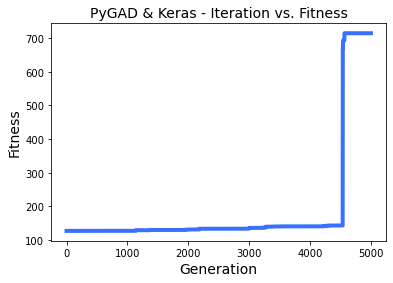

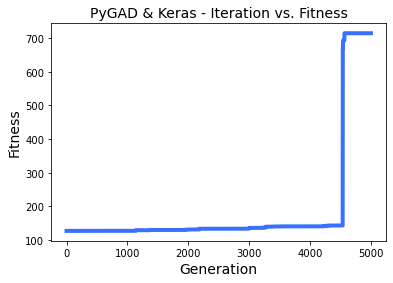

In [26]:
#model = instatiate(input_state, mode, 2) ## comment to avoid the recomputation of weights
model = tf.keras.models.load_model('model_dense_GA_3')

keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=20)
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 5000 # Number of generations.
num_parents_mating = 3 # Number of solutions to be selected as parents in the mating pool.
stabilise_in = 4
stabilisation_check = 7

initial_population = keras_ga.population_weights # Initial population of network weights
data = (input_state, neigh_state, feature_state, ground_state)
fitness_function = fitness_factory(model, forward_with_state, data, stabilise_in, stabilisation_check)

ga_instance = pygad.GA(num_generations=num_generations,
                       keep_parents=2,
                       random_mutation_min_val=-2,
                       init_range_low=-50,
                       init_range_high=50,
                       random_mutation_max_val=2,
                       mutation_probability=0.01,
                       parent_selection_type="rws",
                       crossover_probability=0.001,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_function,
                       on_generation=callback_generation_factory(50))

ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)

## GA evaluation

In [31]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
solution_weights = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
model.set_weights(solution_weights)
result = input_state
for i in range(stabilise_in):
  result = forward_with_state(result, neigh_state, feature_state, model, False)
print(result * n)
print(ground_state * n)
fitness_function(pygad.kerasga.model_weights_as_vector(model), 0)

Fitness value of the best solution = 714.2030172760661
Index of the best solution : 0
tf.Tensor(
[[[1.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 5.0941778e+05 4.2869570e+06]]

 [[0.0000000e+00 6.7734775e+05 3.9913952e+06]]

 [[0.0000000e+00 6.5917795e+06 0.0000000e+00]]

 [[0.0000000e+00 6.5917795e+06 0.0000000e+00]]

 [[0.0000000e+00 6.5917795e+06 0.0000000e+00]]

 [[0.0000000e+00 6.5917795e+06 0.0000000e+00]]

 [[0.0000000e+00 6.5917795e+06 0.0000000e+00]]], shape=(8, 1, 3), dtype=float32)
tf.Tensor(
[[  0.]
 [  1.]
 [  2.]
 [  3.]
 [100.]
 [100.]
 [100.]
 [100.]], shape=(8, 1), dtype=float32)


714.2030172760661

In [27]:
model.save('model_dense_GA_4')

INFO:tensorflow:Assets written to: model_dense_GA_4/assets
